# Assignment 4 – CSCI 450 | Malek Elaghel

## Imports.

In [1]:
import numpy as np, os, matplotlib.pyplot as plt

from skimage import io, transform
from skimage.feature import hog

from sklearn import svm
from sklearn.metrics import accuracy_score

## Question 1.

### Use the image dataset given at this link (Caltech 101) and do the following:
### a. Download and unzip the files (just the images), and set them up in such a manner that each class is in a separate folder.
### b. Write a program to find to average images of the 100 classes, like the one given below, taken from the same link (leave out the BACKGROUND_Google class). Resize every image to a standard square such as 100x100 or 256x256 before adding. Display the average as a single collage image (not a plot full of subplots). The order of the classes is not important. [20 points]

In [2]:
path = "101_ObjectCategories"

# Initialize variables to store statistics
max_num_images = 0
min_num_images = float('inf')
max_height = 0
min_height = float('inf')
max_width = 0
min_width = float('inf')


# Get the list of class folders
class_folders = [folder for folder in os.listdir(
    path) if folder[0] != '.' and folder != 'BACKGROUND_Google' and folder != 'Faces']  # Exclude Faces_easy because Prof. Banerji's grid seems to exclude one Faces folder and BACKGROUND_Google folders

# Initialize an array to store the number of images in each class
class_sizes = np.zeros_like(class_folders, dtype=np.int64)


# Initialize a list to store average images as NumPy arrays
avg_images = np.empty((len(class_folders), 256, 256, 3), dtype=np.uint8)


def im_normalize(image):
    if len(image.shape) == 2:
        image = np.stack((image, image, image), axis=-1)

    image = (image - image.min()) / (image.max() - image.min()) * 255
    return image.astype(np.uint8)

for i, class_folder in enumerate(class_folders): # Loop through all the folders in the path.
    # Get the path of the class folder
    class_path = os.path.join(path, class_folder)
    num_images = len(os.listdir(class_path))
    class_sizes[i] = num_images

    # Update statistics
    max_num_images = max(max_num_images, num_images)
    min_num_images = min(min_num_images, num_images)


    # Collect image files, read them, and resize to 256x256
    image_paths = [os.path.join(class_path, filename) for filename in os.listdir(
        class_path) if filename.lower().endswith(('.jpg', '.jpeg', '.png'))] # Get the path of the image files in the class folder
    
    images = np.empty((len(image_paths), 256, 256, 3), dtype=np.uint8) # Initialize an empty array to store the images

    for j, image_path in enumerate(image_paths): # Loop through all the images in the class folder
        image = io.imread(image_path)
        height, width = image.shape[:2]
        max_height = max(max_height, height)
        min_height = min(min_height, height)
        max_width = max(max_width, width)
        min_width = min(min_width, width)
        image = transform.resize(image, (256, 256, 3), anti_aliasing=True) # Resize the image to 256x256 with 3 channels (RGB)
        images[j] = im_normalize(image)  # Normalize the image and store it in the images array

    # Calculate the average image for this class as a NumPy array
    if images.shape[0] > 0: # If there are images in the class folder
        avg_image = np.mean(images, axis=0)
        avg_images[i] = avg_image
        line = f'\rProcessed class {i+1} of {len(class_folders)}: {class_folder}'
        print(line, end='')


Processed class 100 of 100: yin_yanghairar

In [3]:
class_sizes 

array([ 55, 800,  42,  42,  47,  54,  46,  33, 128,  98,  43,  85,  91,
        50,  43, 123,  47,  59,  62, 107,  47,  69,  73,  70,  50,  51,
        57,  67,  52,  65,  68,  75,  64,  53,  64,  85, 435,  67,  67,
        45,  34,  34,  51,  99, 100,  42,  54,  88,  80,  31,  64,  86,
       114,  61,  81, 200,  78,  41,  66,  43,  40,  87,  32,  76, 798,
        55,  35,  39,  47,  38,  45,  53,  34,  57,  82,  59,  49,  40,
        63,  39,  84,  57,  35,  64,  45,  86,  59,  64,  35,  85,  49,
        86,  75, 239,  37,  59,  34,  56,  39,  60], dtype=int64)

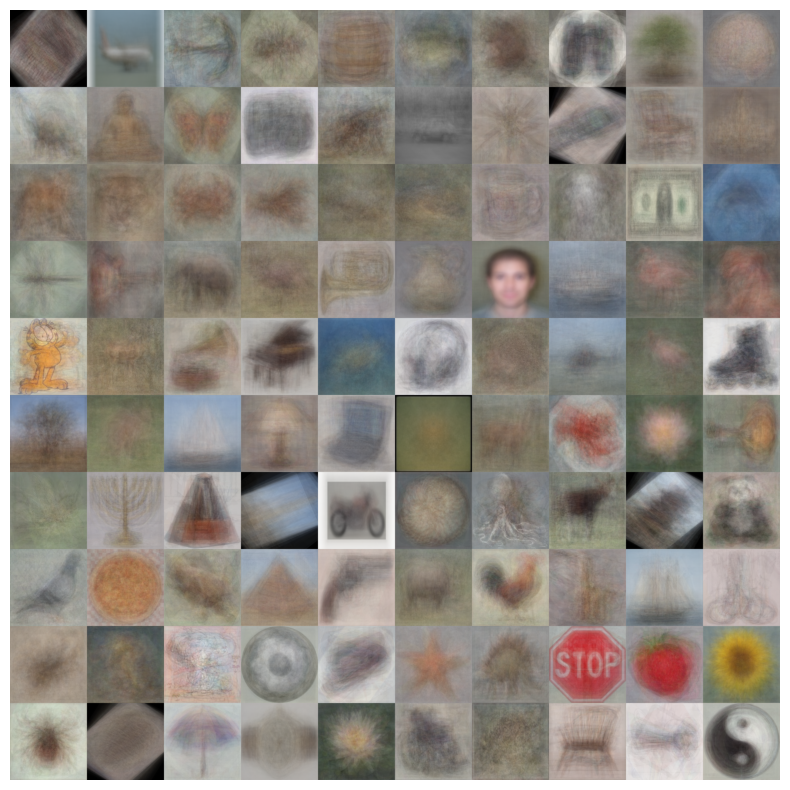

In [4]:
num_rows = 10  # Number of rows in the grid
num_cols = 10  # Number of columns in the grid

# Create a blank canvas for the grid
grid_image = np.zeros((256 * num_rows, 256 * num_cols, 3), dtype=np.uint8)

# Populate the grid with average images
for i, avg_image in enumerate(avg_images):
    row = i // num_cols
    col = i % num_cols
    grid_image[row * 256:(row + 1) * 256, col *
               256:(col + 1) * 256, ...] = avg_image
    # Copilot helped me with the above line, but I understand the logic now.

# Display the grid of average images
plt.figure(figsize=(10, 10))
plt.imshow(grid_image)
plt.axis('off')
plt.show()


## Question 2.

### Collect and display the following statistics about the data (you could collect it while doing the previous part too, but display it separately) [10 points]
#### a. The maximum number of images in a class
#### b. The minimum number of images in a class
#### c. The maximum and minimum height of an image
#### d. The maximum and minimum width of an image

In [5]:
print(f'Maximum number of images in a class: {max_num_images}')
print(f'Minimum number of images in a class: {min_num_images}')
print(f'Maximum height of an image: {max_height}')
print(f'Minimum height of an image: {min_height}')
print(f'Maximum width of an image: {max_width}')
print(f'Minimum width of an image: {min_width}')

Maximum number of images in a class: 800
Minimum number of images in a class: 31
Maximum height of an image: 494
Minimum height of an image: 92
Maximum width of an image: 457
Minimum width of an image: 80


## Question 3.

### Train an SVM classifier using the HOG features of all the images of the airplane class as positive samples, and HOG features of images from the top three largest classes other than the airplane class as the negative samples (largest class = class with most images. This can be found while calculating the previous  answer). Now pass all images other than the training images through the classifier and display any 25 that get a positive response (i.e., the classifier says they’re airplanes).


In [6]:
# Exclude "airplanes" class while sorting
sorted_class_indexes = sorted(
    (idx for idx, size in enumerate(class_sizes)
     if class_folders[idx] != "airplanes"),
    key=lambda idx: class_sizes[idx],
    reverse=True)
top_three_largest_indexes = sorted_class_indexes[:3]  # Select the top 3 largest classes


In [7]:
top_three_class_names = [class_folders[i]
                          for i in top_three_largest_indexes]
top_three_class_lengths = [class_sizes[i]
                            for i in top_three_largest_indexes]
print(top_three_class_names)
print(top_three_class_lengths)
sum(top_three_class_lengths) # Check this with negative samples

['Motorbikes', 'Faces_easy', 'watch']
[798, 435, 239]


1472

In [8]:
# Initialize lists to store HOG features and labels
positive_samples = []  # For "airplanes" class
negative_samples = []  # For top three largest classes (excluding "airplanes")
labels = []

# Parameters for HOG feature extraction
orientations = 8
pixels_per_cell = (16, 16)
cells_per_block = (1, 1)

# Iterate through classes to extract HOG features
for class_index, class_folder in enumerate(class_folders): #test with one class
    folder = os.path.join(path, class_folder)

    # Check if the class is "airplanes" (positive samples)
    is_airplanes_class = (class_folder == "airplanes")

    # Skip HOG feature extraction for classes that don't match the criteria
    if not is_airplanes_class and class_index not in top_three_largest_indexes: #there's probably a better way to do this, but i'm tired zzz
        continue

    print(f"{class_index}: Extracting HOG features from {class_folder}...")


    # Iterate through images in the class folder
    for filename in os.listdir(folder):


        image = io.imread(os.path.join(folder, filename))
        image = im_normalize(image)
        image = transform.resize(image, (256, 256, 3), anti_aliasing=True)


        # Extract HOG features from the image
        fd = hog(image, orientations=orientations, pixels_per_cell=pixels_per_cell,
                    cells_per_block=cells_per_block, visualize=False, channel_axis=2)

        # Determine if it's a positive or negative sample
        if is_airplanes_class:
            positive_samples.append(fd)
            labels.append(1)  # Positive label
        elif class_index in sorted_class_indexes[:3]:
            negative_samples.append(fd)
            labels.append(-1)  # Negative label


# Convert lists to NumPy arrays
positive_samples = np.array(positive_samples)
negative_samples = np.array(negative_samples)
labels = np.array(labels)

1: Extracting HOG features from airplanes...
36: Extracting HOG features from Faces_easy...
64: Extracting HOG features from Motorbikes...
93: Extracting HOG features from watch...


In [9]:
positive_samples.shape, negative_samples.shape, labels.shape

((800, 2048), (1472, 2048), (2272,))

In [10]:
len(positive_samples)+len(negative_samples)

2272

In [11]:
# Combine positive and negative samples
samples = np.vstack((positive_samples, negative_samples))

# Train an SVM classifier
clf = svm.SVC()
clf.fit(samples, labels)


SVC()

In [12]:

predicted_labels = []
predicted_airplanes_images = []


# Parameters for HOG feature extraction
orientations = 8
pixels_per_cell = (16, 16)
cells_per_block = (1, 1)

# Iterate through classes to extract HOG features
for class_index, class_folder in enumerate(class_folders):
    folder = os.path.join(path, class_folder)

    # Check if the class is "airplanes" (positive samples)
    is_airplanes_class = (class_folder == "airplanes")

    # Skip HOG feature extraction for classes that don't match the criteria
    # there's probably a better way to do this, but i'm tired zzz
    if is_airplanes_class or class_index in top_three_largest_indexes:
        continue

    print(f"\r{class_index}: Extracting HOG features from {class_folder}...")

    # Iterate through images in the class folder
    for filename in os.listdir(folder):

        image = io.imread(os.path.join(folder, filename))
        image = im_normalize(image)
        image = transform.resize(image, (256, 256, 3), anti_aliasing=True)

        # Extract HOG features from the image
        test_fd = hog(image, orientations=orientations, pixels_per_cell=pixels_per_cell,
                 cells_per_block=cells_per_block, visualize=False, channel_axis=2)

        # Predict whether it's an airplane or not
        predicted_label = clf.predict([test_fd])
        predicted_labels.append(predicted_label[0])
        # If the image is predicted as an airplane, add its image to the list
        if predicted_label[0] == 1:
            predicted_airplanes_images.append(image)


# Convert list to NumPy array
predicted_labels = np.array(predicted_labels)
actual_labels = np.full(len(predicted_labels), -1)


0: Extracting HOG features from accordion...
2: Extracting HOG features from anchor...
3: Extracting HOG features from ant...
4: Extracting HOG features from barrel...
5: Extracting HOG features from bass...
6: Extracting HOG features from beaver...
7: Extracting HOG features from binocular...
8: Extracting HOG features from bonsai...
9: Extracting HOG features from brain...
10: Extracting HOG features from brontosaurus...
11: Extracting HOG features from buddha...
12: Extracting HOG features from butterfly...
13: Extracting HOG features from camera...
14: Extracting HOG features from cannon...
15: Extracting HOG features from car_side...
16: Extracting HOG features from ceiling_fan...
17: Extracting HOG features from cellphone...
18: Extracting HOG features from chair...
19: Extracting HOG features from chandelier...
20: Extracting HOG features from cougar_body...
21: Extracting HOG features from cougar_face...
22: Extracting HOG features from crab...
23: Extracting HOG features from 

In [13]:
# Calculate accuracy

# The logic here is that we know none of the test images are airplanes, so we can just compare the predicted labels to an array of -1s
accuracy = accuracy_score(
    np.array([-1] * len(predicted_labels)), predicted_labels)
print(f"Accuracy: {accuracy:.3f}")


Accuracy: 0.843


In [21]:
# compare with accuracy score.
1-len(predicted_airplanes_images)/len(predicted_labels)

0.8430485762144053

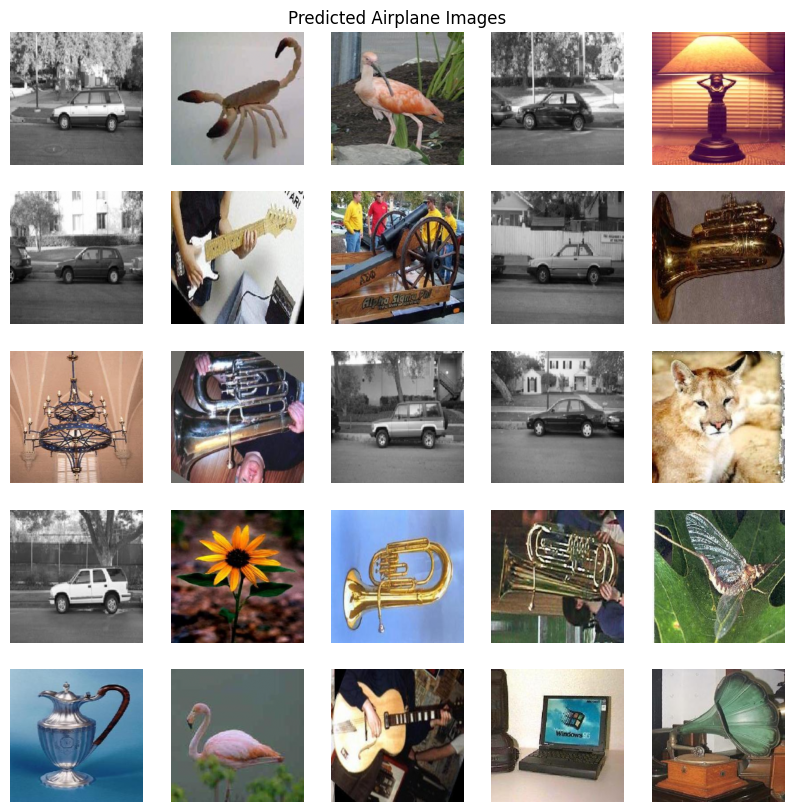

In [20]:
# Convert the list of predicted airplane images to a NumPy array
predicted_airplanes_images = np.array(predicted_airplanes_images)

# Shuffle the array of predicted airplane images
np.random.shuffle(predicted_airplanes_images)

# Display 25 shuffled images that are predicted as airplanes
plt.figure(figsize=(10, 10))
plt.title("Predicted Airplane Images")
plt.axis('off')

for i in range(min(25, len(predicted_airplanes_images))):
    plt.subplot(5, 5, i+1)
    image = predicted_airplanes_images[i]

    plt.imshow(image)
    plt.axis('off')


plt.show()
